<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn import svm
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt


Ahora, cargamos los datos de prueba en los arreglos `X_train` y `y_train`:

In [52]:
df    = pd.read_csv('demanda.csv')

## Procesamos datos de entrenamiento 
dftrain = df.loc[df.iloc[:,20].isin(['T'])] ## 'T' = training set
y_train = dftrain['Y'].to_numpy()  
X_train = dftrain[['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']].to_numpy() ## Regresores

## Procesamos datos de prueba 
dftest = df.loc[df.iloc[:,20].isin(['F'])] ## 'F' = test set
y_test = dftest['Y'].to_numpy()
X_test = dftest[['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']].to_numpy() ## Regresores

In [53]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
r_sq = model.score(X_test, y_test)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)
y_pred = model.predict(X_test)
mae_rlm  = trunc(mean_absolute_error(y_test,y_pred),4)
mse_rlm  = trunc(mean_squared_error(y_test,y_pred),4)
mape_rlm = trunc(mean_absolute_percentage_error(y_test,y_pred),4)

In [ ]:
mae_svm = []; mse_svm = []; mape_svm = []; Clist = []; perc_within_eps_list = []
epsilon = 20
for c in range(1, 100, 1):
    Clist.append(c)
    model = svm.SVR(kernel='rbf', C=c, epsilon=epsilon)
    model.fit(X_train, y_train)
    r_sq = model.score(X_test, y_test)
    print('coefficient of determination:', r_sq)
    
    y_pred = model.predict(X_test)
    mae_svm.append(trunc(mean_absolute_error(y_test,y_pred),4))
    mse_svm.append(trunc(mean_squared_error(y_test,y_pred),4))
    mape_svm.append(trunc(mean_absolute_percentage_error(y_test,y_pred),4))
    
    perc_within_eps = 100*np.sum(abs(y_test-y_pred) <= epsilon) / len(y_test)
    perc_within_eps_list.append(perc_within_eps)

In [ ]:
print('| REGRESIÓN      | C              | MAE            | MSD            | MAPE         | % WITHIN EPSILON = ',epsilon,'       |')
print('| :------------- | :------------- | -------------: | -------------: |-------------:|-------------:|')
print('|    lineal      |         ',       0,'    |    ',str(mae_rlm),'  |    ',str(mse_rlm),'    |    ',str(mape_rlm),'|' )
for i in range(len(Clist)):
    print('|     SVM        |       ',  Clist[i]  ,'    |    ',str(mae_svm[i]),'   |    ',
       str(mse_svm[i]),'    |    ',str(mape_svm[i]),'    |    ',str(perc_within_eps_list[i]),'|',)


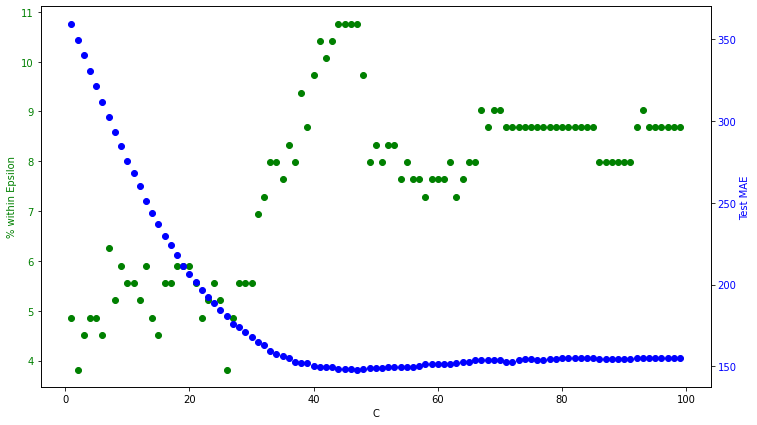

In [73]:
fig, ax1 = plt.subplots(figsize=(12,7))

color='green'
ax1.set_xlabel('C')
ax1.set_ylabel('% within Epsilon', color=color)
ax1.scatter(Clist, perc_within_eps_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color='blue'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Test MAE', color=color)  # we already handled the x-label with ax1
ax2.scatter(Clist, mae_svm, color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.show()

In [61]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#https://github.com/tomsharp/SVR/blob/master/SVR.ipynb
parameters = {'kernel':('linear', 'rbf'), 'C':Clist,} #'epsilon': np.linspace(1, 500)
model = svm.SVR()
clf   = GridSearchCV(model, parameters,scoring='neg_mean_absolute_error', cv=5)
clf.fit(X_train, y_train)
print(sorted(clf.cv_results_.keys()))
print(clf.best_estimator_)
model = clf.best_estimator_
model.fit(X_train, y_train)

r_sq = model.score(X_test, y_test)
print('coefficient of determination:', r_sq)
    
y_pred = model.predict(X_test)

['mean_fit_time', 'mean_score_time', 'mean_test_score', 'param_C', 'param_kernel', 'params', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_fit_time', 'std_score_time', 'std_test_score']
SVR(C=54)
coefficient of determination: 0.8002363165218531


[https://towardsdatascience.com/an-introduction-to-support-vector-regression-svr-a3ebc1672c2](https://towardsdatascience.com/an-introduction-to-support-vector-regression-svr-a3ebc1672c2)

[Grid Search over C and Epsilon](https://github.com/tomsharp/SVR/blob/master/SVR.ipynb)

https://scikit-learn.org/stable/modules/svm.html

https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html

https://medium.com/pursuitnotes/support-vector-regression-in-6-steps-with-python-c4569acd062d